# Data curation of HTR3A protein data from ExCAPE-DB Data






# Scope of the tutorial
*   Input data from Excape dataset for HTR3A protein target
*   AMPL will be used to accomplish the following steps: 
  *   Standardize SMILES string
  *   Clean the data (look for duplicates, average the assay data, cluster the compounds etc.)
  *   Curate the data
  *   Carry out some Exploratory Data Analysis (Chemical space exploration; PCA etc.) 

# Time on COLAB-Pro ( ~ 3 minutes)

# Protein target (HTR3A) information

The Target specific data was downloaded from https://zenodo.org/record/173258#.X_44kuhKi70

Please refer to the ExCAPE-DB publication (https://pubmed.ncbi.nlm.nih.gov/28316655/) for details about the database 

Here are some details about HTR3A gene (taken from RefSeq NCBI)

*   Proteins belongs to GPCR superfamily
*   HTR3a is a receptor for Serotonin, a biogenic hormone that functions as a neurotransmitter
*   HTR3A (also the name of the gene) encodes the subunit of the type 3 receptor for neurotransmitter 
*   Herteromeric combination of subunit A and B (HTR3B) is needed for full function. 
*   Different alternately spliced transcript variant forms for this gene are available.  

Diseases associated with HTR3A include Irritable Bowel Syndrome and Motion Sickness.

## Basic information about HTR3A gene:

**Present in** Chromosome 11
**Exon count:** 10

mRNA and protein information

*   NM_000869.6 → NP_000860.3 
*   NM_001161772.3 → NP_001155244.1
*   NM_213621.4 → NP_998786.3 

## Before you begin, make sure you close all other COLAB notebooks. 

# Change Runtime settings
If you have access to COLAB-Pro (commercial/not-free), please change your runtime settings to use GPU and high-memory,

```Runtime --> Change Runtime Type --> GPU with high-RAM```

If you are not a paid COLAB-Pro customer, you can still choose GPU, with standard-RAM.

In [1]:
!date # starting time 

Fri Sep  3 20:51:28 UTC 2021


## Install AMPL 


In [2]:
! pip install rdkit-pypi
! pip install --pre deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install llvmlite==0.35.0  --ignore-installed
! pip install umap-learn
! pip install molvs
! pip install bravado

     |████████████████████████████████| 19.7 MB 5.3 MB/s 
     |████████████████████████████████| 597 kB 7.4 MB/s 
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3564 sha256=3d17746b35a17342325af589826a3ceeee193dc9155c2282780cf8cef6fdfcf6
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap
     |████████████████████████████████| 25.3 MB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.51.2 requires llvmlite<0.35,>=0.34.0.dev0, but you have llvmlite 0.35.0 which is incompatible.
     |████████████████████████████████| 80 kB 4.9 MB/s 
     |████████████████████████████████| 1.1 MB 25.5 MB/s 
     |████████████████████████████████| 24.6 MB 1.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=d90cbede

In [3]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

--2021-09-03 20:52:09--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1127 (1.1K) [text/plain]
Saving to: ‘install_AMPL_GPU_test.sh’

install_AMPL_GPU_te 100%[===================>]   1.10K  --.-KB/s    in 0s      

2021-09-03 20:52:09 (43.7 MB/s) - ‘install_AMPL_GPU_test.sh’ saved [1127/1127]

Cloning into 'AMPL'...
remote: Enumerating objects: 4180, done.
remote: Counting objects: 100% (1710/1710), done.
remote: Compressing objects: 100% (1054/1054), done.
remote: Total 4180 (delta 1157), reused 819 (delta 642), pack-reused 2470
Receiving objects: 100% (4180/4180), 49.97 MiB | 19.98 MiB/s, done.
Resolving deltas: 100% (2464/2464), done.
Branch 'deepchem_25' se

## Exploring target activity data from selected database
## Data source = ExcapeDB
## Target activity = HTR3A

In [4]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')
import json
import requests
import sys

In [5]:
#
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass, os

# Select a target to work with 
# (e.g. PDE2A, KCNH2, SCNA5)

In [6]:
target_name='HTR3A'
ofile=target_name+'_excape_curated.csv'

In [7]:
import io
url = 'https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/Excape_HTR3A.tsv'
download = requests.get(url).content

In [8]:
# Reading the downloaded content and turning it into a pandas dataframe
data = pd.read_csv(io.StringIO(download.decode('utf-8')), sep='\t', header=0 )

# define data locations 
<!-- ## get username to use as a unique identifier to work in shared directories -->

## Load previously saved raw data

In [9]:
data.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES
0,AATPYXMXFBBKFO-KARVIEMNNA-N,CHEMBL526307,3359,N,1.00000,chembl20,565951,9606,HTR3A,2102,InChI=1/C14H17IN4O2/c1-7(2)8-4-11(20-3)9(15)5-...,C=1C(=C(OC2=CN=C(N=C2N)N)C=C(C1OC)I)C(C)C
1,ABIDZKZAFOTHFB-CCUGXXBONA-N,CHEMBL1271790,3359,A,8.17000,chembl20,674333,9606,HTR3A,2102,InChI=1/C21H28N4O3/c1-13-11-27-12-14(2)25(13)2...,C1C2CCN(C1)C[C@H]2NC(C3=C4N=C(OC4=CC=C3)N5[C@H...
2,ABSDJNLAUZQHJY-UHFFFAOYNA-N,CHEMBL2205048,3359,A,7.21000,chembl20,880265,9606,HTR3A,2102,InChI=1/C17H20N2OS/c1-20-14-5-4-6-15(13-14)21-...,N1(CCNCC1)C=2C(=CC=CC2)SC=3C=C(C=CC3)OC
3,ACKJXXOVSOCBPX-PHLAQJRANA-N,11376655,79246,A,8.25181,pubchem,652569,10116,HTR3A,2102,InChI=1/C36H46N6O/c1-26-33(27-14-6-9-17-30(27)...,O=C(NCCCCCCCNC=1C=2CCCCC2N=C3C1C=CC=C3)C4=C(C(...
4,ACKJXXOVSOCBPX-PHLAQJRANA-N,CHEMBL195241,3359,A,8.25000,chembl20,462123,9606,HTR3A,2102,InChI=1/C36H46N6O/c1-26-33(27-14-6-9-17-30(27)...,C=1(N=C2C=CC=CC2=C(C1C)C(=O)NCCCCCCCNC=3C4=C(C...


In [10]:
data.rename( columns={ "pXC50" : "PXC50", "Ambit_InchiKey" : "compound_id" }, inplace=True)
data.head()

,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,PXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES
0,AATPYXMXFBBKFO-KARVIEMNNA-N,CHEMBL526307,3359,N,1.00000,chembl20,565951,9606,HTR3A,2102,InChI=1/C14H17IN4O2/c1-7(2)8-4-11(20-3)9(15)5-...,C=1C(=C(OC2=CN=C(N=C2N)N)C=C(C1OC)I)C(C)C
1,ABIDZKZAFOTHFB-CCUGXXBONA-N,CHEMBL1271790,3359,A,8.17000,chembl20,674333,9606,HTR3A,2102,InChI=1/C21H28N4O3/c1-13-11-27-12-14(2)25(13)2...,C1C2CCN(C1)C[C@H]2NC(C3=C4N=C(OC4=CC=C3)N5[C@H...
2,ABSDJNLAUZQHJY-UHFFFAOYNA-N,CHEMBL2205048,3359,A,7.21000,chembl20,880265,9606,HTR3A,2102,InChI=1/C17H20N2OS/c1-20-14-5-4-6-15(13-14)21-...,N1(CCNCC1)C=2C(=CC=CC2)SC=3C=C(C=CC3)OC
3,ACKJXXOVSOCBPX-PHLAQJRANA-N,11376655,79246,A,8.25181,pubchem,652569,10116,HTR3A,2102,InChI=1/C36H46N6O/c1-26-33(27-14-6-9-17-30(27)...,O=C(NCCCCCCCNC=1C=2CCCCC2N=C3C1C=CC=C3)C4=C(C(...
4,ACKJXXOVSOCBPX-PHLAQJRANA-N,CHEMBL195241,3359,A,8.25000,chembl20,462123,9606,HTR3A,2102,InChI=1/C36H46N6O/c1-26-33(27-14-6-9-17-30(27)...,C=1(N=C2C=CC=CC2=C(C1C)C(=O)NCCCCCCCNC=3C4=C(C...


In [11]:
# import os
# working_dir=tmp_dir
curated_file=ofile

In [12]:
data['SMILES']

0              C=1C(=C(OC2=CN=C(N=C2N)N)C=C(C1OC)I)C(C)C
1      C1C2CCN(C1)C[C@H]2NC(C3=C4N=C(OC4=CC=C3)N5[C@H...
2                N1(CCNCC1)C=2C(=CC=CC2)SC=3C=C(C=CC3)OC
3      O=C(NCCCCCCCNC=1C=2CCCCC2N=C3C1C=CC=C3)C4=C(C(...
4      C=1(N=C2C=CC=CC2=C(C1C)C(=O)NCCCCCCCNC=3C4=C(C...
                             ...                        
644    [C@@H]12N([C@@H](C[C@H](C1)NC(C3=C4C(OC(=N4)N5...
645    N=1C(N(C(C2CC(CCC12)C)=O)N)=CCCCN3CCN(CC3)C=4N...
646    O=C(NC1C[C@@H]2N([C@H](C1)CCC2)C)C3=C4OC(=NC4=...
647    [C@@H]12N([C@@H](C[C@H](C1)NC(C3=C4C(N=C(O4)C=...
648    N=1C(N(C(C2CCCCC12)=O)N)=CCCCN3CCN(CC3)C=4N=C5...
Name: SMILES, Length: 649, dtype: object

In [13]:
# Generate SMILES, InChI keys for dataset with curation and structure modules.
# RDkit modules are used to process the SMILES strings

data['rdkit_smiles'] = data['SMILES'].apply(curate_data.base_smiles_from_smiles)
# data['inchi_key'] = data['smiles'].apply(struct_utils.smiles_to_inchi_key)

In [14]:
print(data.shape)
print(data['rdkit_smiles'].value_counts()[0:10])

(649, 13)
NCCc1c[nH]c2ccc(O)cc12                                 3
Cn1ncc(-c2ccc(OCCCN3CCCCCC3)cc2)cc1=O                  2
Cc1nn(-c2ccccn2)c(=O)cc1-c1ccc(OCCCN2CCC[C@H]2C)cc1    2
Clc1cnc2nc(N3CCN4CCC3CC4)oc2c1                         2
Cc1nnc(O)cc1-c1ccc(OCCCN2CCC[C@H]2C)cc1                2
Oc1cc(-c2ccc(OCCCN3CCCCC3)cc2)cnn1                     2
O=C1c2cc(Cl)cc3cnn(c23)CCN1[C@@H]1CN2CCC1CC2           2
Cc1ccc(Sc2ccccc2N2CCNCC2)c(C)c1                        2
C[C@H]1CCCN1CCCOc1ccc(-c2cnn(-c3ccccn3)c(=O)c2)cc1     2
Cc1nnc(O)cc1-c1ccc(OCCCN2CCCCC2)cc1                    2
Name: rdkit_smiles, dtype: int64


In [15]:
# import os
# working_dir=tmp_dir
# ofile=target_name+'_excape_curated.csv.'+username

# column: Response values column
column = 'PXC50'

# tolerance: Percentage of individual respsonse values allowed to different from 
# the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 1

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'rdkit_smiles'

# column that will be averaged ; smiles_col; used to find the replicates
# 

curated_df = curate_data.average_and_remove_duplicates(column, tolerance, 
                                                       list_bad_duplicates, 
                                                       data, max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)
# curated_file = os.path.join(working_dir, ofile)
## discard out of range values
curated_df=curated_df[curated_df['VALUE_NUM_mean']>2]
curated_df.to_csv(curated_file, index=False)

Bad duplicates removed from dataset
Dataframe size (643, 17)
List of 'bad' duplicates removed
                     compound_id    PXC50  ...   Perc_Var  VALUE_NUM_std
36   BSNKYWSMUAGMDO-UHFFFAOYNA-N  6.57025  ...  11.638406       1.223846
37   BSNKYWSMUAGMDO-UHFFFAOYNA-N  8.30103  ...  11.638406       1.223846
227  JBVRKZZSTULWTO-OAHLLOKONA-N  9.30103  ...  15.893248       1.803851
228  JBVRKZZSTULWTO-OAHLLOKONA-N  6.75000  ...  15.893248       1.803851
548  WLINCFBAKQHMPZ-OAHLLOKONA-N  8.19382  ...   9.661653       1.020935
549  WLINCFBAKQHMPZ-OAHLLOKONA-N  6.75000  ...   9.661653       1.020935

[6 rows x 5 columns]

Dataset de-duplicated
Dataframe size (602, 17)
New column created with averaged values:  VALUE_NUM_mean


## Note this includes the compounds discarded by measurement variation and out of range values

In [16]:
curated_df['Remove_BadDuplicate'].value_counts()

0    596
Name: Remove_BadDuplicate, dtype: int64

In [17]:
compound_id='rdkit_smiles'
reject=data[~data[compound_id].isin(curated_df[compound_id])]
reject

,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,PXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES,rdkit_smiles
0,AATPYXMXFBBKFO-KARVIEMNNA-N,CHEMBL526307,3359,N,1.00000,chembl20,565951,9606,HTR3A,2102,InChI=1/C14H17IN4O2/c1-7(2)8-4-11(20-3)9(15)5-...,C=1C(=C(OC2=CN=C(N=C2N)N)C=C(C1OC)I)C(C)C,COc1cc(C(C)C)c(Oc2cnc(N)nc2N)cc1I
36,BSNKYWSMUAGMDO-UHFFFAOYNA-N,11184481,15561,A,6.57025,pubchem,460741,10090,HTR3A,2102,InChI=1/C14H18N4O/c1-10-2-3-12-13(15-10)16-14(...,O1C(N2C3CCN(CC3)CC2)=NC=4N=C(C=CC14)C,Cc1ccc2oc(N3CCN4CCC3CC4)nc2n1
37,BSNKYWSMUAGMDO-UHFFFAOYNA-N,11184481,3359,A,8.30103,pubchem,460743,9606,HTR3A,2102,InChI=1/C14H18N4O/c1-10-2-3-12-13(15-10)16-14(...,O1C(N2C3CCN(CC3)CC2)=NC=4N=C(C=CC14)C,Cc1ccc2oc(N3CCN4CCC3CC4)nc2n1
169,GVOCXQUIZNWEMU-YAQRNVERNA-N,14712103,3359,N,NaN,pubchem,616534,9606,HTR3A,2102,InChI=1/C12H15N3/c1-2-4-11(5-3-1)8-13-7-6-12-9...,N(CCC=1NC=NC1)CC2=CC=CC=C2,c1ccc(CNCCc2cnc[nH]2)cc1
227,JBVRKZZSTULWTO-OAHLLOKONA-N,69937162,3359,A,9.30103,pubchem,1141224,9606,HTR3A,2102,InChI=1/C17H19ClN4O/c18-13-7-12-9-19-22-6-5-21...,ClC=1C=C2C(=O)N([C@H]3C4CCN(C3)CC4)CCN5N=CC(=C...,O=C1c2cc(Cl)cc3cnn(c23)CCN1[C@@H]1CN2CCC1CC2
228,JBVRKZZSTULWTO-OAHLLOKONA-N,CHEMBL3261483,15561,A,6.75000,chembl20,1350972,10090,HTR3A,2102,InChI=1/C17H19ClN4O/c18-13-7-12-9-19-22-6-5-21...,C1=C(C=C2C=3N(N=C2)CCN(C(C13)=O)[C@H]4C5CCN(C4...,O=C1c2cc(Cl)cc3cnn(c23)CCN1[C@@H]1CN2CCC1CC2
321,NECSKBYJMMVETP-UHFFFAOYNA-N,CHEMBL3233402,3359,N,1.29000,chembl20,1337830,9606,HTR3A,2102,InChI=1/C31H36N4O2/c1-32-29(36)31(26-14-6-2-7-...,C1(C(N(C(N1CCCCCN2CCN(CC2)C3=CC=CC=C3)=O)C)=O)...,CN1C(=O)N(CCCCCN2CCN(c3ccccc3)CC2)C(c2ccccc2)(...
331,NRJJRVIMKKANAW-UHFFFAOYNA-N,1408942,3359,N,NaN,pubchem,616534,9606,HTR3A,2102,InChI=1/C15H18N4/c1-18-7-9-19(10-8-18)15-11-14...,N1(CCN(CC1)C)C=2N=CN=C(C2)C3=CC=CC=C3,CN1CCN(c2cc(-c3ccccc3)ncn2)CC1
344,OGPREQIZGSIMHW-JLGFQASFNA-N,71459241,3359,N,NaN,pubchem,709378,9606,HTR3A,2102,"InChI=1/C16H28N4O/c1-16(2,3)13-12-14(19-18-13)...",O=C(NC1=NNC(C(C)(C)C)=C1)CCCN2CCCCC2,CC(C)(C)c1cc(NC(=O)CCCN2CCCCC2)n[nH]1
526,VJEBGMIAGKMECI-FNGIMCLKNA-N,76316933,3359,N,NaN,pubchem,643471,9606,HTR3A,2102,InChI=1/C27H32N8O4/c1-33-18-7-6-8-19(33)16-17(...,O=C(NC1C[C@H]2N([C@@H](C1)CCC2)C)C3=NN(C4=C3C=...,CN1[C@H]2CCC[C@@H]1CC(NC(=O)c1nn(CCCCNc3ccc([N...


## save rejected molecules for further examination

In [18]:
print("Number of discarded compounds",reject[compound_id].nunique())

ofile=target_name+'.reject_check.csv'
reject.to_csv(ofile,index=False)

Number of discarded compounds 9


(0.0, 12.0)

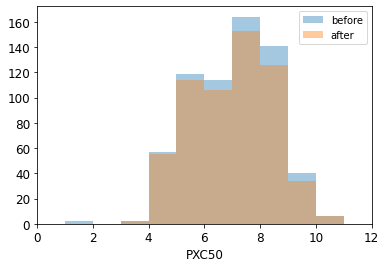

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()

# This will be our before curation
before=data["PXC50"]

# current curated dataframe will not include any out of range values
after=curated_df["PXC50"]

sns.distplot(before, bins=range(0, 12, 1), ax=ax, kde=False, label='before')
sns.distplot(after, bins=range(0, 12, 1), ax=ax, kde=False, label='after')
plt.legend()
ax.set_xlim([0, 12])

Post-processing dataset

Total Number of results = 596
dataset mean = 6.9555837080536875 NM
dataset stdev = 1.4751039669352373 NM
dataset max = 10.5 NM
dataset min = 3.06 NM



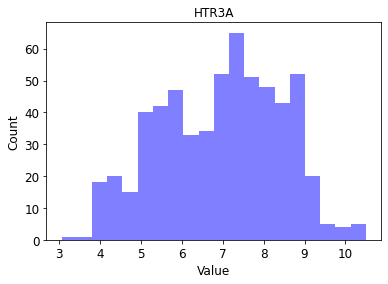

In [20]:
column = 'PXC50'
num_bins = 20
title = target_name
units = 'NM'
filepath = ""
data=curated_df

curate_data.summarize_data(column, num_bins, title, units, filepath, data)

In [21]:
!date #ending time

Fri Sep  3 20:52:40 UTC 2021


In [22]:
curated_df.head()

,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,PXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,InChI,SMILES,rdkit_smiles,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
1,ABIDZKZAFOTHFB-CCUGXXBONA-N,CHEMBL1271790,3359,A,8.17000,chembl20,674333,9606,HTR3A,2102,InChI=1/C21H28N4O3/c1-13-11-27-12-14(2)25(13)2...,C1C2CCN(C1)C[C@H]2NC(C3=C4N=C(OC4=CC=C3)N5[C@H...,C[C@H]1COC[C@H](C)N1c1nc2c(C(=O)N[C@@H]3CN4CCC...,8.170000,NaN,0.000000,0
2,ABSDJNLAUZQHJY-UHFFFAOYNA-N,CHEMBL2205048,3359,A,7.21000,chembl20,880265,9606,HTR3A,2102,InChI=1/C17H20N2OS/c1-20-14-5-4-6-15(13-14)21-...,N1(CCNCC1)C=2C(=CC=CC2)SC=3C=C(C=CC3)OC,COc1cccc(Sc2ccccc2N2CCNCC2)c1,7.210000,NaN,0.000000,0
3,ACKJXXOVSOCBPX-PHLAQJRANA-N,11376655,79246,A,8.25181,pubchem,652569,10116,HTR3A,2102,InChI=1/C36H46N6O/c1-26-33(27-14-6-9-17-30(27)...,O=C(NCCCCCCCNC=1C=2CCCCC2N=C3C1C=CC=C3)C4=C(C(...,Cc1c(N2CCN(C)CC2)nc2ccccc2c1C(=O)NCCCCCCCNc1c2...,8.250905,0.00128,0.010968,0
5,ADYMTDFOOCWUHC-UHFFFAOYNA-N,CHEMBL305582,3359,A,8.13000,chembl20,3480,9606,HTR3A,2102,InChI=1/C19H22N4/c1-2-6-16(7-3-1)10-13-23-18-9...,C=1(N(C2=CC=CC=C2N1)CCC3=CC=CC=C3)N4CCNCC4,c1ccc(CCn2c(N3CCNCC3)nc3ccccc32)cc1,8.130000,NaN,0.000000,0
6,AFLJKKMTBWNZFE-KAASGWQYNA-N,CHEMBL378349,3359,A,6.76000,chembl20,851152,9606,HTR3A,2102,InChI=1/C16H18N2OS/c19-16(13-2-1-12-5-8-20-15(...,C1N2CCC([C@@H](NC(C3=CC4=C(C=C3)C=CS4)=O)C2)C1,O=C(N[C@H]1CN2CCC1CC2)c1ccc2ccsc2c1,6.760000,NaN,0.000000,0


In [23]:
curated_df.shape

(596, 17)

In [24]:
!date

Fri Sep  3 20:52:40 UTC 2021
